In [41]:
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
import copy


class BayesianABTest:
    '''
    This class is used for performing Bayesian A/B testing.

    Attributes:
        data_A (numpy array): Data from group A.
        data_B (numpy array): Data from group B.
        priors (dict): Prior distributions for the parameters.
        posterior_samples (dict): Posterior samples obtained after fitting the model.
    '''
    
    def __init__(self, data_A, data_B, priors):
        '''
        The constructor for BayesianABTest class.

        Parameters:
            data_A (numpy array): Data from group A.
            data_B (numpy array): Data from group B.
            priors (dict): Prior distributions for the parameters.
        '''
        self.data_A = data_A
        self.data_B = data_B
        self.priors = copy.deepcopy(priors)
        self.posterior_samples = None

    def model(self, data_A, data_B):
        '''
        The model definition for the Bayesian A/B test.

        Parameters:
            data_A (numpy array): Data from group A.
            data_B (numpy array): Data from group B.
        '''
        mu_A = numpyro.sample('mu_A', self.priors['mu_A'])
        mu_B = numpyro.sample('mu_B', self.priors['mu_B'])
        sigma_A = numpyro.sample('sigma_A', self.priors['sigma_A'])
        sigma_B = numpyro.sample('sigma_B', self.priors['sigma_B'])
        numpyro.sample('data_A_obs', dist.Normal(mu_A, sigma_A), obs=data_A)
        numpyro.sample('data_B_obs', dist.Normal(mu_B, sigma_B), obs=data_B)

    def plot_distributions(self, priors, title):
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))

        for ax, (param, dist) in zip(axs.ravel(), priors.items()):
            rng_key = jax.random.PRNGKey(0)
            samples = dist.sample(rng_key, (10000,))
            sns.histplot(samples, ax=ax, kde=True)
            ax.set_title(f'{title} of {param}')

        plt.tight_layout()
        plt.show()

    def plot_posterior_samples(self):
        posterior_samples = self.posterior_samples
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        for ax, (param, samples) in zip(axs.ravel(), posterior_samples.items()):
            sns.histplot(samples, ax=ax, kde=True)
            ax.set_title(f'Posterior distribution of {param}')
        plt.tight_layout()
        plt.show()

    def plot_posterior_samples_dens(self):
        fig, axs = plt.subplots(2, figsize=(10, 8))

        sns.kdeplot(self.posterior_samples['mu_A'], ax=axs[0], fill=True, label="Store A", color='blue')
        sns.kdeplot(self.posterior_samples['mu_B'], ax=axs[0], fill=True, label="Store B", color='orange')
        axs[0].set_title('Posterior distributions of mu')
        axs[0].legend()

        sns.kdeplot(self.posterior_samples['sigma_A'], ax=axs[1], fill=True, label="Store A", color='blue')
        sns.kdeplot(self.posterior_samples['sigma_B'], ax=axs[1], fill=True, label="Store B", color='orange')
        axs[1].set_title('Posterior distributions of sigma')
        axs[1].legend()

        plt.tight_layout()
        plt.show()


    def run(self):
        # Plot the prior distributions
        self.plot_distributions(self.priors, 'Prior distribution')

        # Run MCMC
        kernel = NUTS(self.model)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=2000)
        mcmc.run(jax.random.PRNGKey(0), data_A=self.data_A, data_B=self.data_B)

        # Extract the posterior samples
        self.posterior_samples = mcmc.get_samples()

        # Plot the posterior distributions
        self.plot_posterior_samples()
        self.plot_posterior_samples_dens()

        # Calculate the required sample size for a power of 0.95
        effect_size = (self.posterior_samples['mu_B'].mean() - self.posterior_samples['mu_A'].mean()) / self.posterior_samples['sigma_A'].mean()
        sample_size = tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.95, ratio=1)
        print(f"Required sample size for 95% power: {sample_size:.2f} per group")

        print( mcmc.print_summary() )
        return mcmc



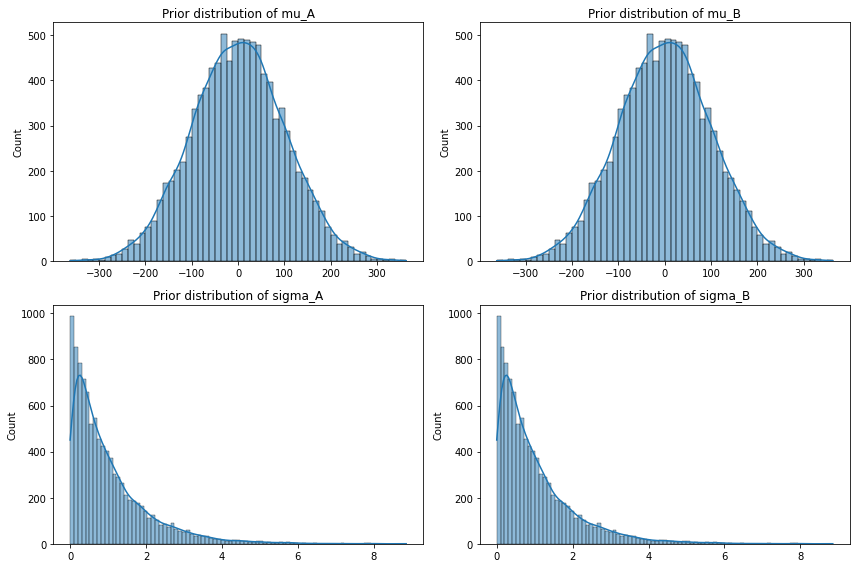

sample: 100%|██████████| 2500/2500 [00:02<00:00, 937.05it/s, 7 steps of size 6.47e-01. acc. prob=0.93] 


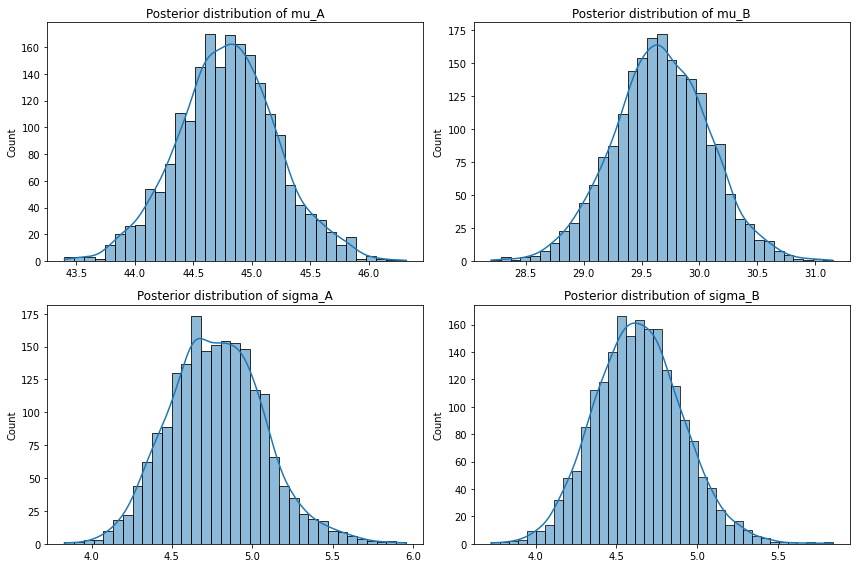

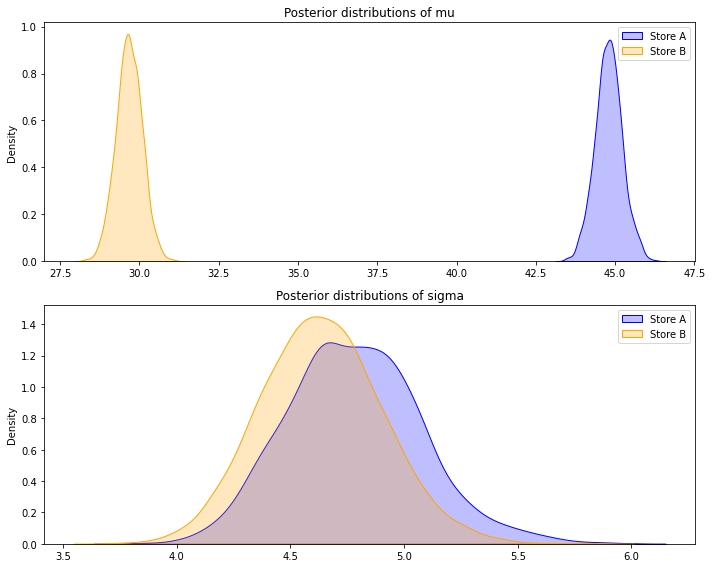

Required sample size for 95% power: 3.88 per group

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A     44.79      0.43     44.80     44.09     45.51   2488.29      1.00
      mu_B     29.67      0.41     29.67     28.96     30.30   2139.42      1.00
   sigma_A      4.78      0.30      4.77      4.28      5.23   1863.37      1.00
   sigma_B      4.64      0.27      4.63      4.19      5.06   1673.82      1.00

Number of divergences: 0
None


In [42]:
# assuming normal distirbution of priors

import pandas as pd

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Separate the data into Store A and Store B after the price change
sales_A = data_daily_normal_loaded.loc[data_daily_normal_loaded['Day'] >= '2023-03-01', 'Sales_Store_A'].values
sales_B = data_daily_normal_loaded.loc[data_daily_normal_loaded['Day'] >= '2023-03-01', 'Sales_Store_B'].values

priors = {
    'mu_A': dist.Normal(0, 100),
    'mu_B': dist.Normal(0, 100),
    'sigma_A': dist.Exponential(1),
    'sigma_B': dist.Exponential(1)
}
ab_test = BayesianABTest(sales_A, sales_B, priors)
ab_test.run()


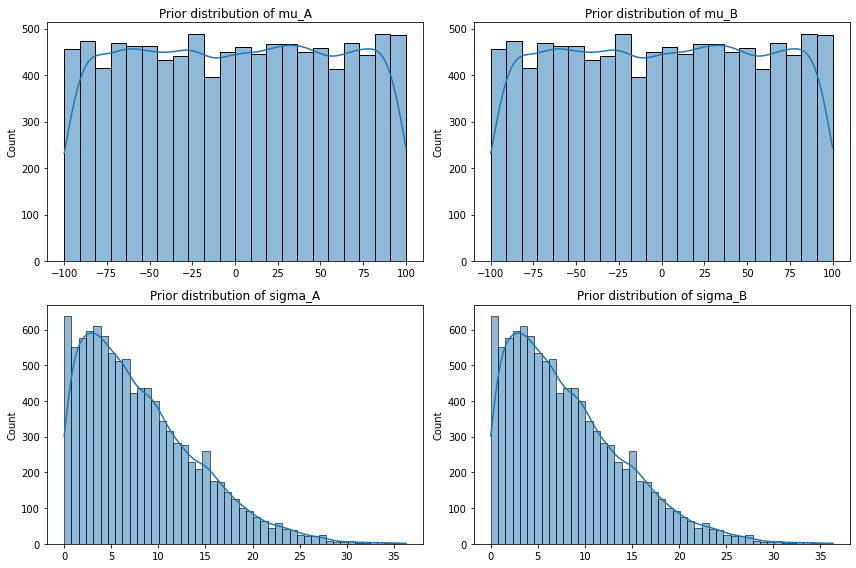

sample: 100%|██████████| 2500/2500 [00:02<00:00, 909.44it/s, 3 steps of size 6.72e-01. acc. prob=0.93] 


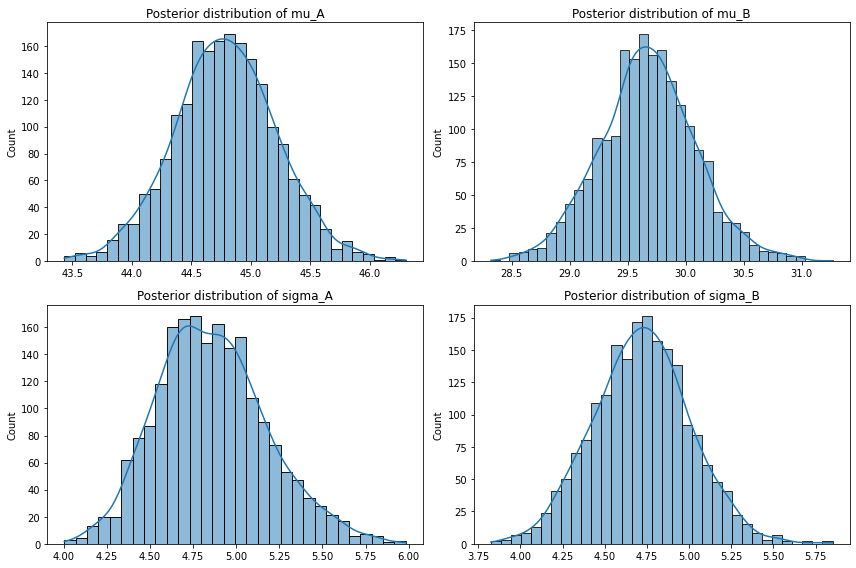

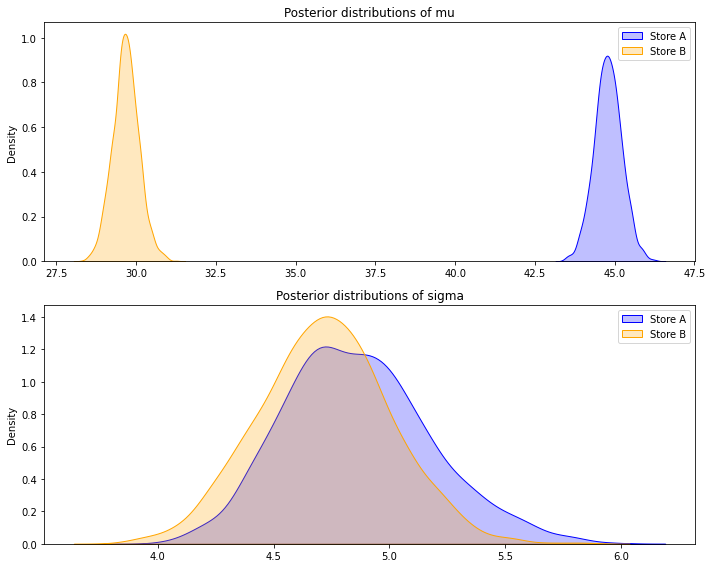

Required sample size for 95% power: 3.96 per group

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A     44.79      0.43     44.79     44.12     45.55   2170.63      1.00
      mu_B     29.68      0.41     29.67     28.98     30.33   2171.87      1.00
   sigma_A      4.86      0.32      4.84      4.34      5.37   2198.15      1.00
   sigma_B      4.72      0.29      4.72      4.28      5.22   1633.67      1.00

Number of divergences: 0
None


In [43]:
# assuming uniform distirbutions as prior

priors = {
    'mu_A': dist.Uniform(-100, 100),
    'mu_B': dist.Uniform(-100, 100),
    'sigma_A': dist.HalfNormal(10),
    'sigma_B': dist.HalfNormal(10)
}
ab_test = BayesianABTest(sales_A, sales_B, priors)
ab_test.run()


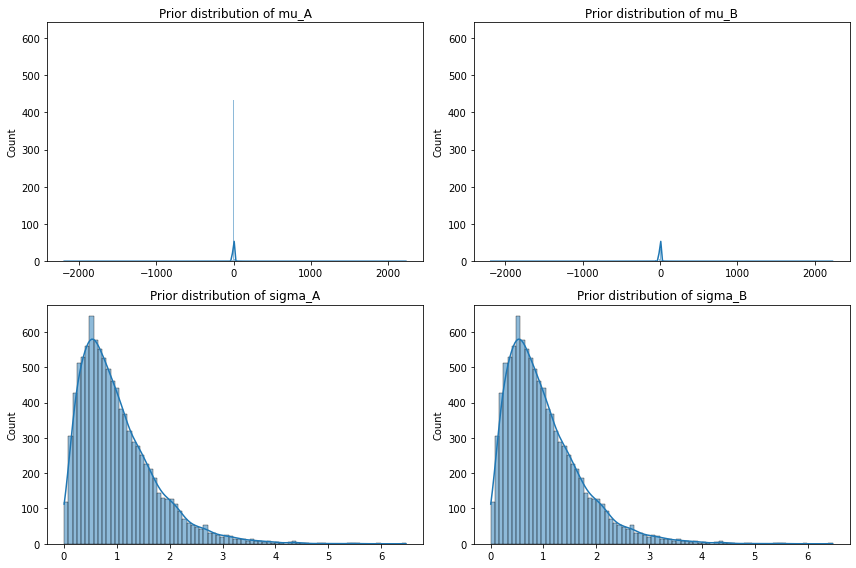

sample: 100%|██████████| 2500/2500 [00:02<00:00, 1004.57it/s, 7 steps of size 7.27e-01. acc. prob=0.91]


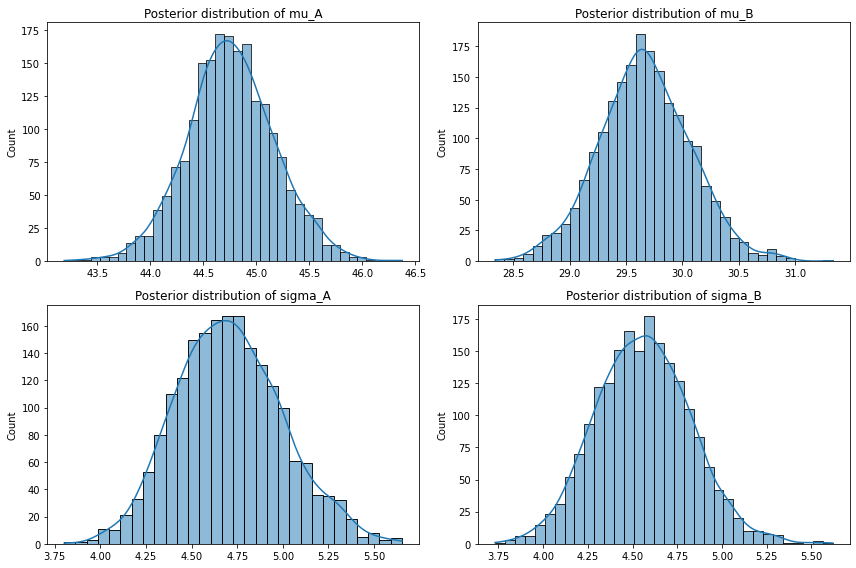

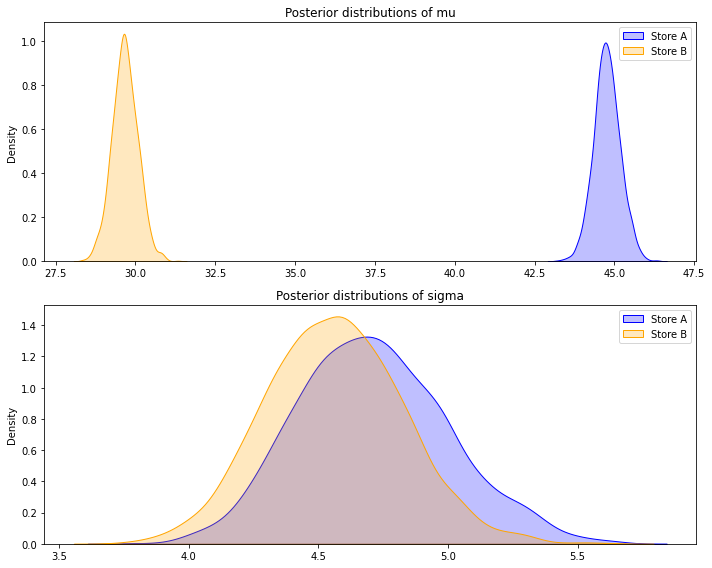

Required sample size for 95% power: 3.82 per group

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A     44.76      0.42     44.75     44.07     45.45   2131.47      1.00
      mu_B     29.67      0.41     29.66     28.99     30.31   2570.21      1.00
   sigma_A      4.71      0.29      4.70      4.21      5.17   2302.72      1.00
   sigma_B      4.56      0.27      4.56      4.10      4.96   1528.82      1.00

Number of divergences: 0
None


In [44]:
#cauchy 

# Define priors
priors = {
    'mu_A': dist.Cauchy(0, 1),
    'mu_B': dist.Cauchy(0, 1),
    'sigma_A': dist.Gamma(2, 2),
    'sigma_B': dist.Gamma(2, 2)
}
ab_test = BayesianABTest(sales_A, sales_B, priors)
ab_test.run()


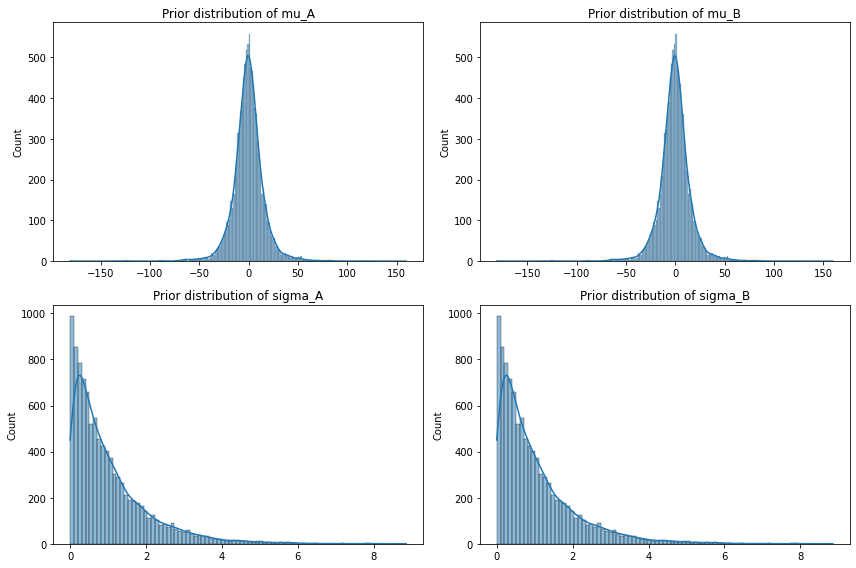

sample: 100%|██████████| 2500/2500 [00:02<00:00, 996.27it/s, 7 steps of size 6.82e-01. acc. prob=0.92] 


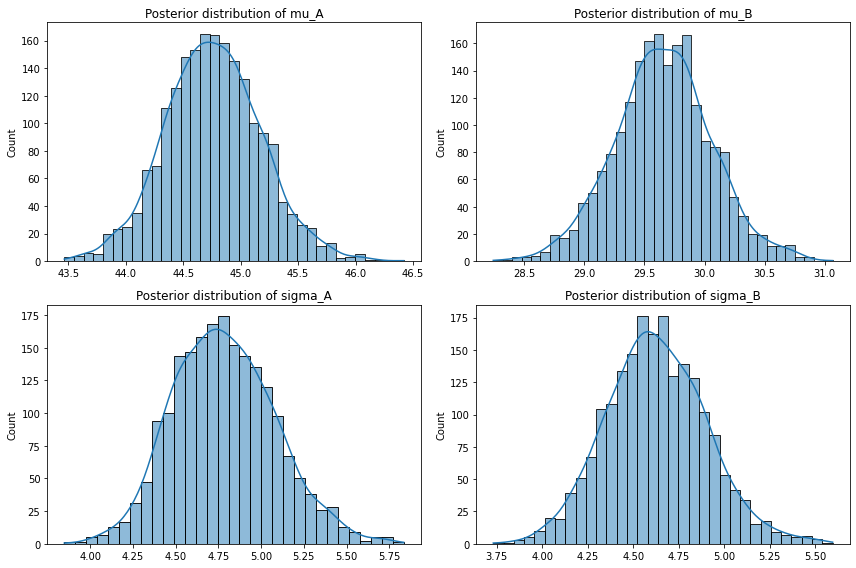

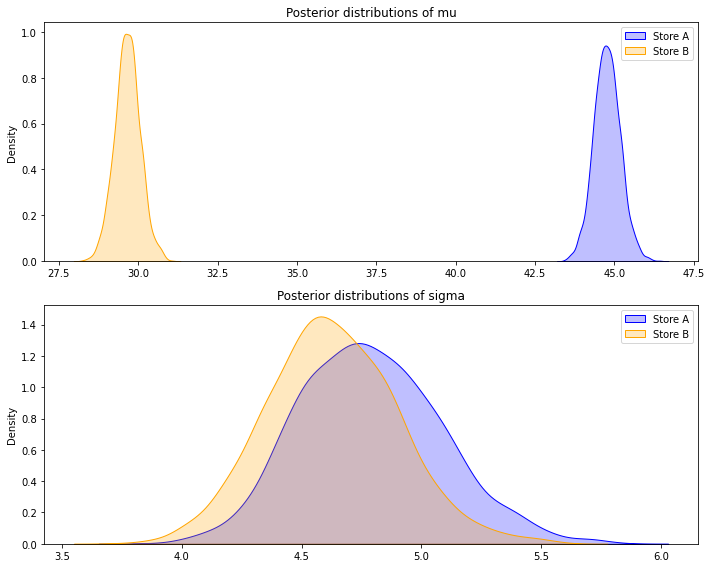

Required sample size for 95% power: 3.89 per group

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A     44.76      0.42     44.75     44.08     45.43   2001.29      1.00
      mu_B     29.66      0.40     29.65     28.98     30.29   2124.31      1.00
   sigma_A      4.78      0.30      4.77      4.27      5.23   2321.63      1.00
   sigma_B      4.63      0.27      4.61      4.17      5.07   2044.26      1.00

Number of divergences: 0
None


In [45]:
# t-stundent distirbutino
# Define priors
priors = {
    'mu_A': dist.StudentT(df=3, loc=0, scale=10),
    'mu_B': dist.StudentT(df=3, loc=0, scale=10),
    'sigma_A': dist.Exponential(rate=1),
    'sigma_B': dist.Exponential(rate=1)
}
ab_test = BayesianABTest(sales_A, sales_B, priors)
ab_test.run()


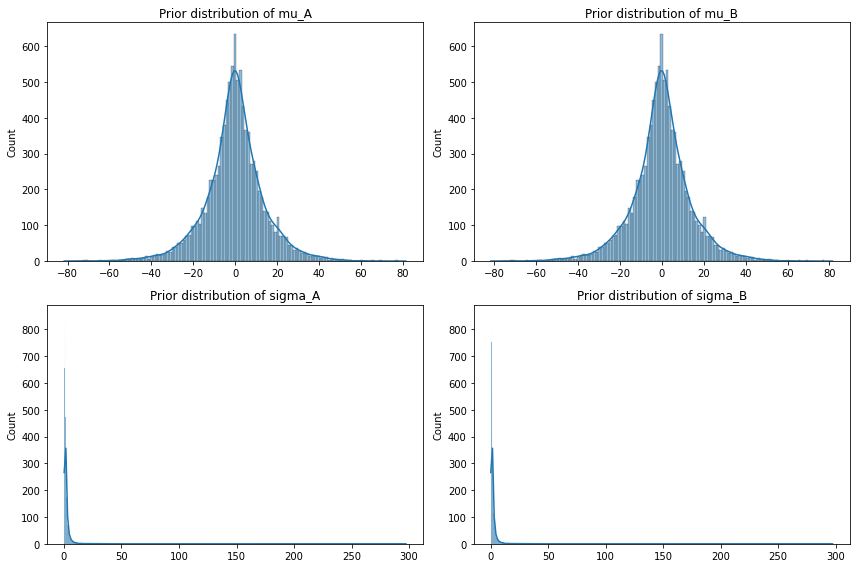

sample: 100%|██████████| 2500/2500 [00:02<00:00, 986.04it/s, 7 steps of size 7.06e-01. acc. prob=0.92] 


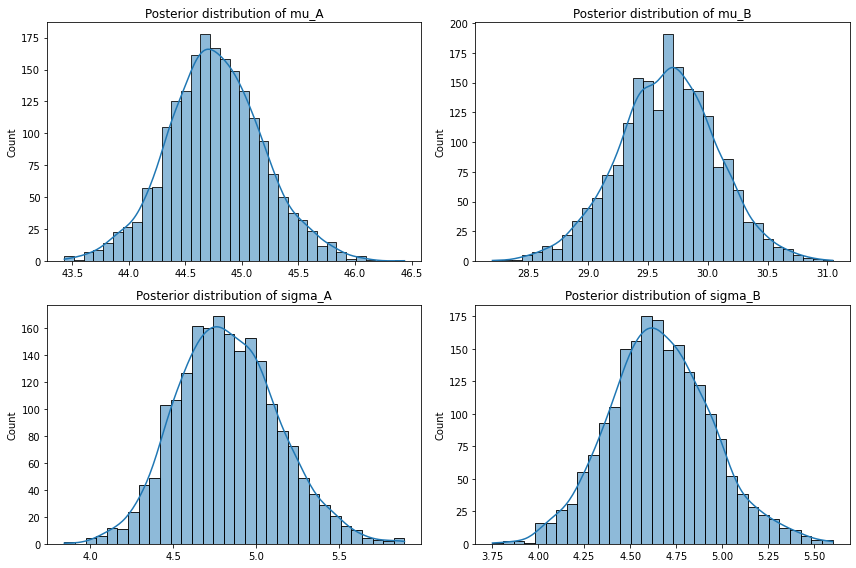

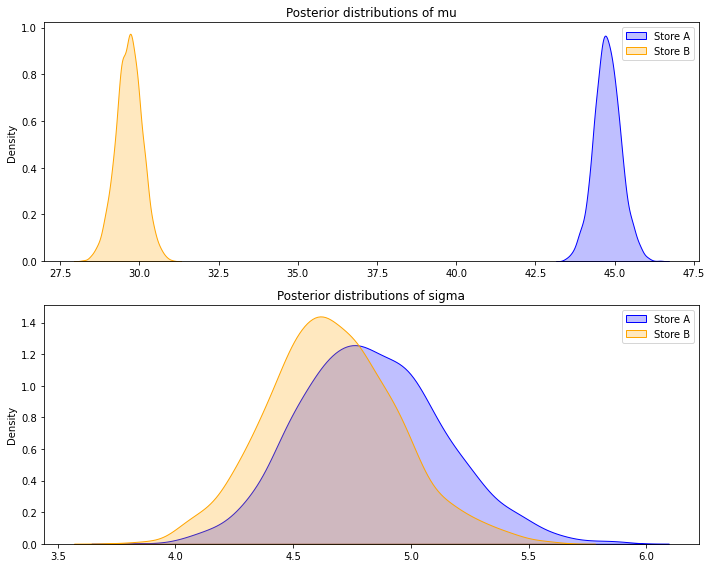

Required sample size for 95% power: 3.94 per group

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A     44.77      0.42     44.75     44.11     45.52   1851.85      1.00
      mu_B     29.66      0.41     29.67     28.92     30.28   2079.43      1.00
   sigma_A      4.83      0.31      4.81      4.31      5.30   2195.60      1.00
   sigma_B      4.66      0.28      4.65      4.19      5.10   1989.54      1.00

Number of divergences: 0
None


In [46]:
#Laplace distirbution
# Define priors
priors = {
    'mu_A': dist.Laplace(loc=0, scale=10),
    'mu_B': dist.Laplace(loc=0, scale=10),
    'sigma_A': dist.InverseGamma(concentration=2, rate=2),
    'sigma_B': dist.InverseGamma(concentration=2, rate=2)
}
ab_test = BayesianABTest(sales_A, sales_B, priors)
ab_test.run()


# Beta distirbution
The Beta distribution is a probability distribution that is defined on the interval [0, 1]. It is parameterized by two positive shape parameters, denoted by \( \alpha \) (alpha) and \( \beta \) (beta), that control the shape of the distribution.

The Beta distribution is often used as a prior distribution in Bayesian statistics for random variables that represent probabilities or proportions, because it is confined to the interval [0, 1].

Here is how you can define priors for \( \mu_A \), \( \mu_B \), \( \sigma_A \), and \( \sigma_B \) using the Beta distribution:




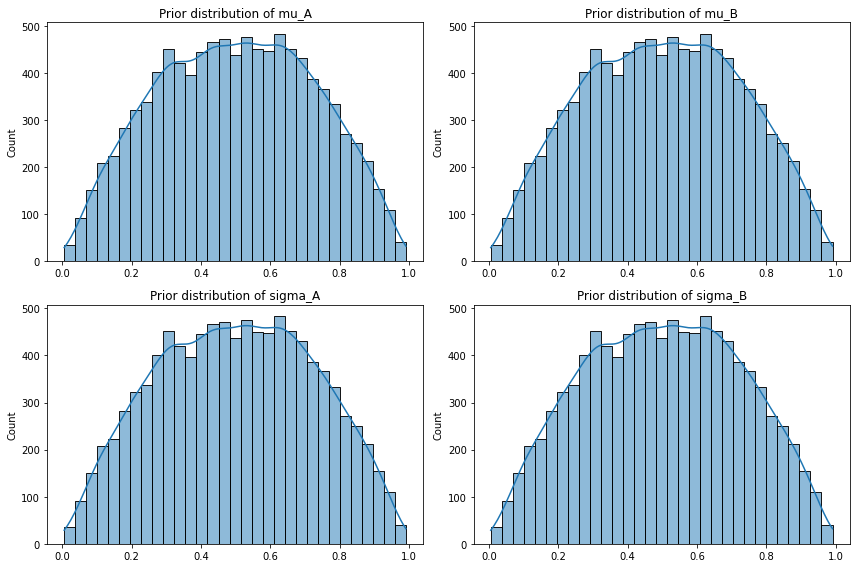

sample: 100%|██████████| 2500/2500 [00:02<00:00, 865.67it/s, 7 steps of size 5.94e-01. acc. prob=0.92] 


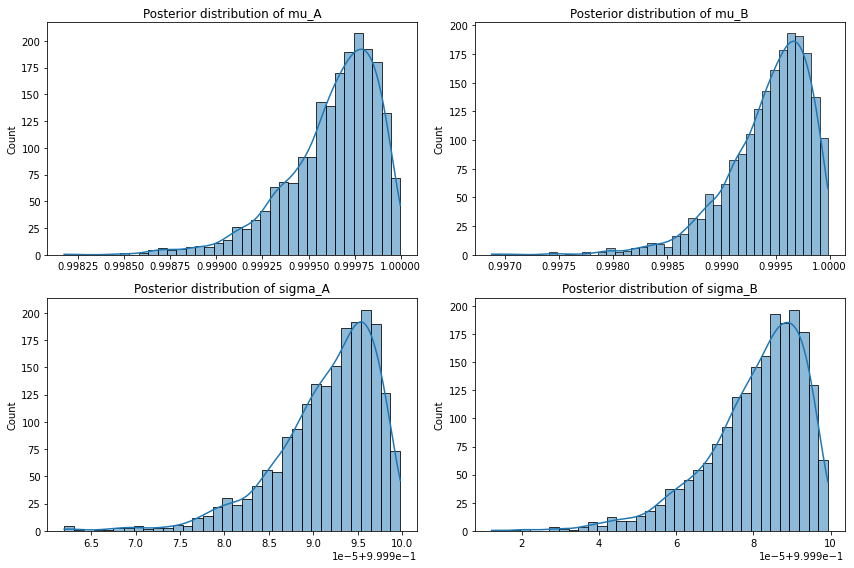

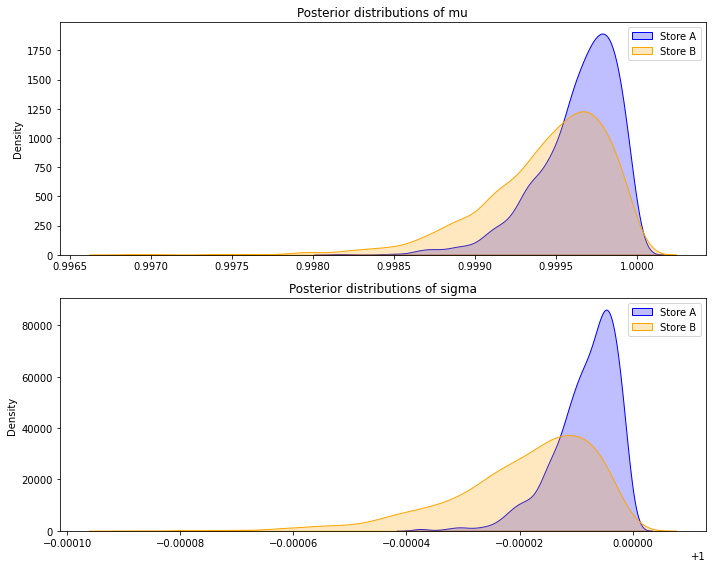

Required sample size for 95% power: 682034563.59 per group

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_A      1.00      0.00      1.00      1.00      1.00   2201.99      1.00
      mu_B      1.00      0.00      1.00      1.00      1.00   2474.46      1.00
   sigma_A      1.00      0.00      1.00      1.00      1.00   2399.81      1.00
   sigma_B      1.00      0.00      1.00      1.00      1.00   1526.71      1.00

Number of divergences: 0
None


In [47]:
priors = {
    'mu_A': dist.Beta(concentration1=2, concentration0=2),
    'mu_B': dist.Beta(concentration1=2, concentration0=2),
    'sigma_A': dist.Beta(concentration1=2, concentration0=2),
    'sigma_B': dist.Beta(concentration1=2, concentration0=2)
}
ab_test = BayesianABTest(sales_A, sales_B, priors)
ab_test.run()



In this case, the `concentration1` and `concentration0` parameters are both set to 2, which results in a Beta distribution that is symmetric around 0.5. 

Please note that while it's technically possible to use the Beta distribution as a prior for any parameter, it's generally not appropriate to use it as a prior for a standard deviation (\( \sigma \)), because the standard deviation is not confined to the interval [0, 1]. A more appropriate choice might be a distribution that only takes positive values, such as the HalfNormal or Exponential distribution.